In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import pickle
import numpy as np
import pandas as pd
import librosa
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
SAMPLE_RATE = 22050
N_FFT = 2048 #int(0.025 * SAMPLE_RATE)  # 25ms frame length
WIN_LENGTH = int(0.025 * SAMPLE_RATE)
HOP_LENGTH = 512 #int(0.010 * SAMPLE_RATE)     # 10ms hop length
N_MFCC = 20  # Number of cepstral coefficients to be extracted
N_MELS =40
DURATION = 30  # Duration of each audio file
NUM_SEGMENTS = 10  # Number of segments per audio file

In [4]:
file_path = "/content/drive/MyDrive/preprocess_new.pkl"

# Load data from pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

In [5]:
def mfcc(audio) :
  mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

  delta_mfcc = librosa.feature.delta(mfcc)
  delta2_mfcc = librosa.feature.delta(mfcc, order=2)
  concanated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
  concanated_mfcc = concanated_mfcc.T
  return concanated_mfcc.tolist()


In [6]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(len(data["train"]["features"])) :
    feature = data["train"]["features"][i]
    label = data["train"]["labels"][i]

    extraction = mfcc(feature)

    X_train.append(extraction)
    y_train.append(label)

for i in range(len(data["val"]["features"])) :
    feature = data["val"]["features"][i]
    label = data["val"]["labels"][i]

    extraction = mfcc(feature)

    X_val.append(extraction)
    y_val.append(label)

for i in range(len(data["test"]["features"])) :
    feature = data["test"]["features"][i]
    label = data["test"]["labels"][i]

    extraction = mfcc(feature)

    X_test.append(extraction)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(5832, 130, 60)
(729, 130, 60)
(729, 130, 60)


In [18]:
def build_model(input_shape):
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(625, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(512))

    # Dense layer
    model.add(keras.layers.Dense(512, activation="relu"))

    model.add(keras.layers.Dense(256, activation="relu"))

    model.add(keras.layers.Dense(128, activation="relu"))

    model.add(keras.layers.Dense(64, activation="relu"))


    # Output layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [8]:
def acc_plot(history):

        fig, axs = plt.subplots()

        # create accuracy subplot
        axs.plot(history.history["accuracy"], label="train accuracy")
        axs.plot(history.history["val_accuracy"], label="val accuracy")
        axs.set_ylabel("Accuracy")
        axs.legend(loc="lower right")
        axs.set_title("Accuracy eval")
        plt.figure(figsize=(10, 5))
        plt.show()

def loss_plot(history) :
        fig, axs = plt.subplots()

        # create loss subplot
        axs.plot(history.history["loss"], label="train loss")
        axs.plot(history.history["val_loss"], label="val loss")
        axs.set_ylabel("Loss")
        axs.set_xlabel("Epoch")
        axs.legend(loc="upper right")
        axs.set_title("Loss eval")
        plt.figure(figsize=(10, 5))
        plt.show()

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 130, 625)          1715000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2330624   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)               

In [20]:

# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# add callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/models/ismir.h5', save_best_only=True)

# train model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
46/46 [==============================] - 12s 165ms/step - loss: 1.1128 - accuracy: 0.5964 - val_loss: 0.9805 - val_accuracy: 0.6241
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 7s 143ms/step - loss: 0.7899 - accuracy: 0.7087 - val_loss: 0.7268 - val_accuracy: 0.7188
Epoch 3/30
46/46 [==============================] - 7s 146ms/step - loss: 0.6842 - accuracy: 0.7593 - val_loss: 0.6873 - val_accuracy: 0.7545
Epoch 4/30
46/46 [==============================] - 7s 148ms/step - loss: 0.5048 - accuracy: 0.8275 - val_loss: 0.6308 - val_accuracy: 0.7709
Epoch 5/30
46/46 [==============================] - 7s 151ms/step - loss: 0.4414 - accuracy: 0.8479 - val_loss: 0.5213 - val_accuracy: 0.8244
Epoch 6/30
46/46 [==============================] - 7s 148ms/step - loss: 0.3294 - accuracy: 0.8860 - val_loss: 0.4827 - val_accuracy: 0.8217
Epoch 7/30
46/46 [==============================] - 7s 148ms/step - loss: 0.2918 - accuracy: 0.8971 - val_loss: 0.5921 - val_accuracy: 0.8025
Epoch 8/30
46/46 [==============================] - 7s 148ms/step - loss: 0.2354 - accuracy: 0.9201 - val_loss: 0.5417 - val_accuracy: 0.8299
Epoch 9/30
46/46 

In [21]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

# Simpan DataFrame ke file Excel
file_path = "nama_file.xlsx"  # Ganti dengan path dan nama file yang diinginkan
history_df.to_excel(file_path, index=False)  # index=False untuk menghindari penulisan index ke dalam file Excel
history_df

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.112831,0.596365,0.980478,0.624143,0
1,0.789875,0.708676,0.726849,0.718793,1
2,0.684176,0.759259,0.687287,0.754458,2
3,0.504755,0.827503,0.630840,0.770919,3
4,0.441430,0.847908,0.521262,0.824417,4
5,0.329384,0.885974,0.482710,0.821674,5
6,0.291818,0.897119,0.592064,0.802469,6
7,0.235401,0.920096,0.541716,0.829904,7
8,0.223085,0.923354,0.416685,0.876543,8
9,0.164080,0.943416,0.449768,0.871056,9


23/23 [==============================] - 1s 24ms/step - loss: 0.5042 - accuracy: 0.8669
Train accuracy: 98.61%
Train loss:  4.01%
Validation accuracy: 89.99%
Validation loss: 44.64%
Test accuracy: 86.69%
Test loss: 50.42%


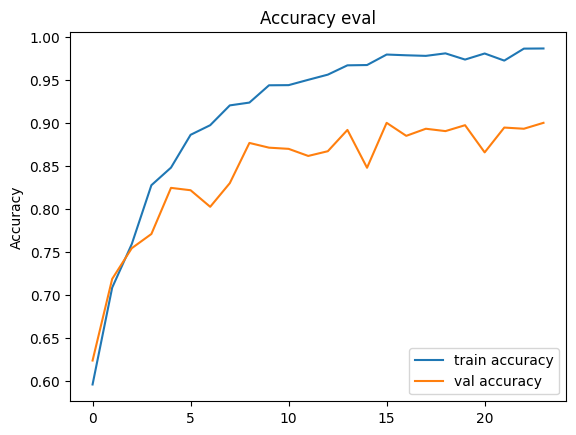

<Figure size 1000x500 with 0 Axes>

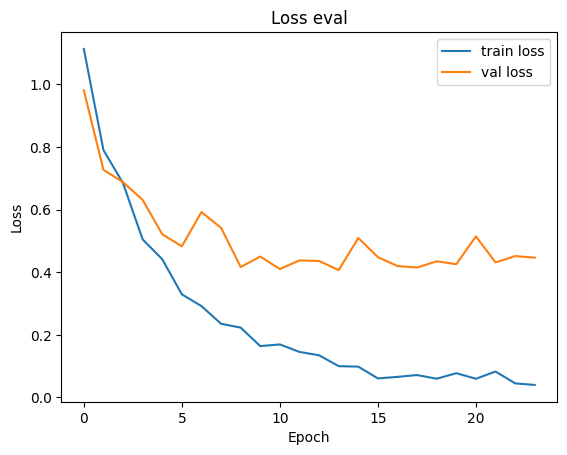

<Figure size 1000x500 with 0 Axes>

In [22]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
acc_plot(history)
loss_plot(history)

23/23 [==============================] - 1s 19ms/step
Confusion Matrix:


<Axes: >

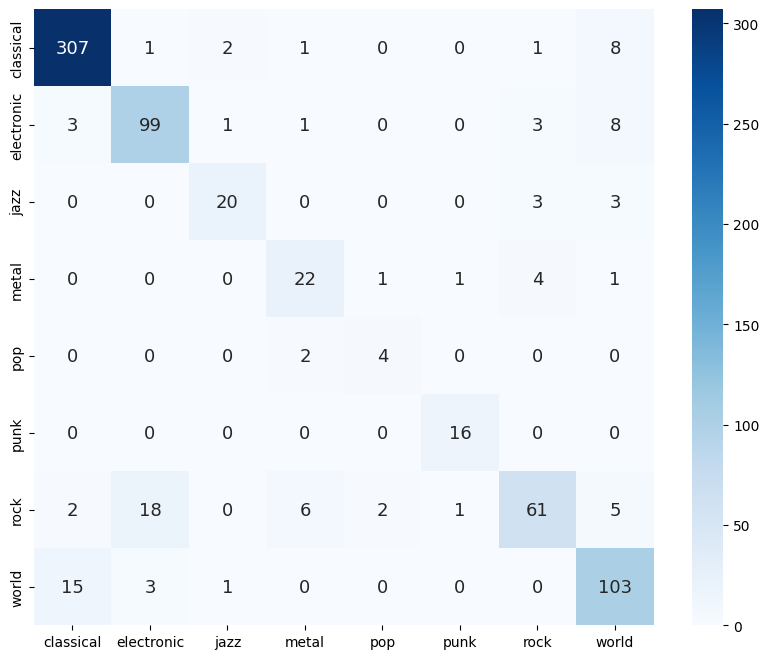

In [23]:
y_pred = model.predict(X_test)
genre_labels = data["mapping"]
confusion = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix:')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=genre_labels, yticklabels=genre_labels, annot_kws={"size": 13})

In [24]:
print('Classification Report')

print(classification_report(y_test, y_pred.argmax(axis=1), target_names=genre_labels))

Classification Report
              precision    recall  f1-score   support

   classical       0.94      0.96      0.95       320
  electronic       0.82      0.86      0.84       115
        jazz       0.83      0.77      0.80        26
       metal       0.69      0.76      0.72        29
         pop       0.57      0.67      0.62         6
        punk       0.89      1.00      0.94        16
        rock       0.85      0.64      0.73        95
       world       0.80      0.84      0.82       122

    accuracy                           0.87       729
   macro avg       0.80      0.81      0.80       729
weighted avg       0.87      0.87      0.86       729

